In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import spacy
from ast import literal_eval
import folium
import re


#need to run this line in terminal to install the Spanish lemmatization library - >> python -m spacy download es_core_news_sm

nlp = spacy.load('es_core_news_sm')


df1 = pd.read_csv('T42 Exemptions Post Consortium 1.csv')

df2 = pd.read_csv("T42 Exemptions Post Consortium II.csv")

df = pd.concat([df1, df2], axis=0)
df

,Name,Carpeta Box (Edna),Date Request to CBP,Date Presented at POE,Group Number,Medical Condition and/or Vulnerability,Explique el crimen o violenica en Mexico,Notas,# Family Members,Tel #,...,HIAS Database,T42 Closing Letter,Date Request Sent to CBP,Vulnerability Points,G28 2,Referred to DMRS 2,Referred to SFDP 2,MyCase Complete 2,Closing Letter,#
0,Robert Kenedy Amaya Diaz,NaN,NaN,NaN,NaN,Epilepsy,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Marlene de Jesus Osorio Escobar,NaN,NaN,NaN,NaN,Chest deformity,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Iris Antonia Cepeda Centeno,NaN,NaN,NaN,NaN,"Diabetes, cancer and kidnapping",NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Michelle Alejandra Alvarado Abregon,NaN,NaN,NaN,NaN,Heart and respiratory issues,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gena Genesis Mejia Mendez,NaN,NaN,NaN,NaN,Microcephaly,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,Meiby Alexandra Castillo Figueredo,checked,NaN,NaN,173.0,Baby was beaten on head when they were assaulted,Were assaulted and robbed on train,Travelling with: Miguel Angel Rodriguez Piña (...,5.0,52 656 3876411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.0
228,Antonio Bolimer,checked,NaN,NaN,174.0,Su primo Wisep se fracturo su brazo a causa de...,A el y a uno de sus primos han sido victimas d...,El viaja con 2 primos hermanos varones adultos...,3.0,"52 962 2157540, 52 656 1134269",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.0
229,Jenny Dalila Flores Montoya,NaN,NaN,NaN,174.0,Ella es Hipertensa,Cuando llego a la ciudad una pareja de matrimo...,Ella (es madre soltera) y viaja con su hijo me...,2.0,52 6561036213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0
230,Mergin Onan Ordonez Salinas,NaN,NaN,NaN,174.0,he has high blood pressure and blood sugar pro...,robbed twice,wife - Nancy Natalie Murillo Cruz\ndaughter - ...,4.0,52 636 1020125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0


In [2]:
def extract_date_from_string(input_string):
    if type(input_string) is not str:
        return None
    # Define a regex pattern to capture the date at the beginning
    date_pattern = r'(\d{2}[._]\d{2}[._]\d{4})'

    # Search for the date pattern in the input string
    match = re.search(date_pattern, input_string)

    # If a match is found, return the matched date
    if match:
        special_chars_pattern = re.compile(r'[^a-zA-Z0-9/]')
        result_string = re.sub(special_chars_pattern, '/', match.group(1))
        if "0202" in result_string:
            result_string = result_string.replace("0202", "2022")

        return result_string
    else:
        return None  # Return None if no date is found

df['Date of G28'] = df['G28'].apply(extract_date_from_string)
date_df = df[['Date Request to CBP','Date Presented at POE', 'Date of G28']]
df['Date Request to CBP'] = pd.to_datetime(df['Date Request to CBP'])
df['Date of G28'] = pd.to_datetime(df['Date of G28'])
df['Date Presented at POE'] = pd.to_datetime(df['Date Presented at POE'])

date_df

,Date Request to CBP,Date Presented at POE,Date of G28
0,NaN,NaN,None
1,NaN,NaN,None
2,NaN,NaN,None
3,NaN,NaN,None
4,NaN,NaN,None
...,...,...,...
227,NaN,NaN,12/08/2022
228,NaN,NaN,12/12/2022
229,NaN,NaN,12/12/2022
230,NaN,NaN,12/12/2022


In [3]:
print(date_df['Date Request to CBP'].isna().sum())

print(date_df['Date of G28'].isna().sum())

print(date_df['Date Presented at POE'].isna().sum())


1010
169
115


In [4]:
final_df = pd.DataFrame()
# Calculate differences between consecutive dates
final_df["Diff between G28 and CBP Request"]  = df['Date Request to CBP'] - df['Date of G28']
final_df["Diff between CBP Request and Date Present at POE"] = df['Date Presented at POE'] - df['Date Request to CBP']
final_df["Diff between G28 and Date at POE"] = df['Date Presented at POE'] - df['Date of G28']
# Concatenate differences from all columns
final_df.to_csv("datediff.csv", index=False)


In [5]:
avg_G28_wait = final_df["Diff between G28 and CBP Request"].mean()

print(f"Average wait time between issuance of G28 and CBP Request: \033[1m{avg_G28_wait.days} days \033[0m")

sorted_column = final_df['Diff between G28 and CBP Request'].sort_values(ascending=False)

# Calculate the highest 10% values
highest_10_percent = sorted_column.head(int(len(sorted_column) * 0.1)).mean()

print(f"Average of longest 10% of wait time between issuance of G28 and CBP Request: \033[1m{highest_10_percent.days} days \033[0m")


# Get the single largest number
largest_number = sorted_column.iloc[1]

print(f"Longest wait time between issuance of G28 and CBP Request: \033[1m {largest_number.days} days \033[0m")

Average wait time between issuance of G28 and CBP Request: 14 days 
Average of longest 10% of wait time between issuance of G28 and CBP Request: 18 days 
Longest wait time between issuance of G28 and CBP Request:  91 days 


In [6]:
avg_CBP_wait = final_df["Diff between CBP Request and Date Present at POE"].mean()

print(f"Average wait time between issuance of CBP Request and Date Present at POE: \033[1m{avg_CBP_wait.days} days \033[0m")

sorted_column = final_df['Diff between CBP Request and Date Present at POE'].sort_values(ascending=False)

# Calculate the highest 10% values
highest_10_percent = sorted_column.head(int(len(sorted_column) * 0.1)).mean()

print(f"Average of longest 10% of wait time between issuance of CBP Request and Date Present at POE: \033[1m{highest_10_percent.days} days \033[0m")


# Get the single largest number
largest_number = sorted_column.iloc[0]

print(f"Longest wait time between issuance of CBP Request and Date Present at POE: \033[1m {largest_number.days} days \033[0m")

Average wait time between issuance of CBP Request and Date Present at POE: 18 days 
Average of longest 10% of wait time between issuance of CBP Request and Date Present at POE: 24 days 
Longest wait time between issuance of CBP Request and Date Present at POE:  35 days 


In [7]:
avg_CBP_to_G28_wait = final_df["Diff between G28 and Date at POE"].mean()

print(f"Average wait time between issuance of G28 and Date Present at POE: \033[1m{avg_CBP_wait.days} days \033[0m")

sorted_column = final_df['Diff between G28 and Date at POE'].sort_values(ascending=False)

# Calculate the highest 10% values
highest_10_percent = sorted_column.head(int(len(sorted_column) * 0.1)).mean()

print(f"Average of longest 10% of wait time between issuance of G28 and Date Present at POE: \033[1m{highest_10_percent.days} days \033[0m")


# Get the single largest number
largest_number = sorted_column.iloc[2]

print(f"Longest wait time between issuance of G28 and Date Present at POE: \033[1m {largest_number.days} days \033[0m")

Average wait time between issuance of G28 and Date Present at POE: 18 days 
Average of longest 10% of wait time between issuance of G28 and Date Present at POE: 75 days 
Longest wait time between issuance of G28 and Date Present at POE:  134 days 


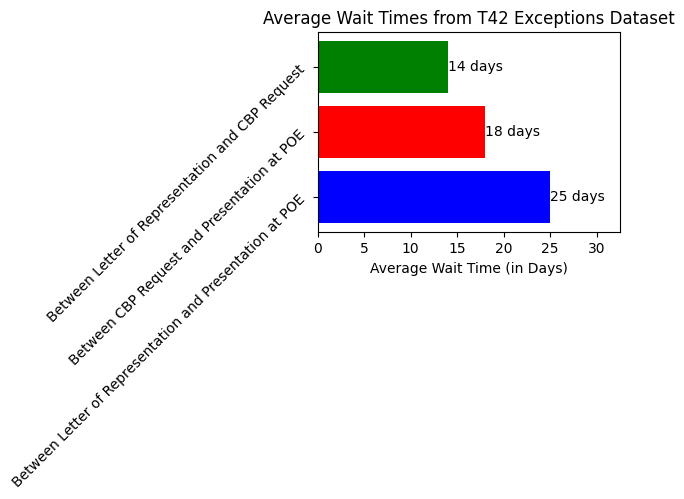

In [29]:
# Plotting the bar
plt.barh("Between Letter of Representation and Presentation at POE", int(avg_CBP_to_G28_wait.days), color='blue')
plt.text(int(avg_CBP_to_G28_wait.days), "Between Letter of Representation and Presentation at POE", f"{str(int(avg_CBP_to_G28_wait.days),)} days", va='center', ha='left')

plt.barh("Between CBP Request and Presentation at POE", int(avg_CBP_wait.days), color='red')
plt.text(int(avg_CBP_wait.days), "Between CBP Request and Presentation at POE", f"{str(int(avg_CBP_wait.days),)} days", va='center', ha='left')

plt.barh("Between Letter of Representation and CBP Request", int(avg_G28_wait.days), color='green')
plt.text(int(avg_G28_wait.days), "Between Letter of Representation and CBP Request", f"{str(int(avg_G28_wait.days),)} days", va='center', ha='left')

# Adding labels and title
plt.xlabel('Average Wait Time (in Days)')
plt.title('Average Wait Times from T42 Exceptions Dataset')

plt.yticks(rotation=45)
plt.xlim(0, value * 1.3)  # Adjust multiplier as needed to provide sufficient space

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
